In [75]:
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
from utils.hedging import run_delta_hedge_analysis
import matplotlib.pyplot as plt

In [76]:
ticker = 'AAPL'
data = pd.read_csv(f"../data/processed/{ticker}_processed.csv")

data['date'] = pd.to_datetime(data['date'])
data['expiration_date'] = pd.to_datetime(data['expiration_date'])

Show how many options do we have per expiration date per moneyness.

In [77]:
per_option = (
    data[['option_id', 'expiration_date', 'initial_moneyness']]
    .drop_duplicates()
)
counts = (
    per_option
    .groupby(['expiration_date', 'initial_moneyness'])
    .size()
    .unstack(fill_value=0)       # columns: ATM / ITM / OTM
    .sort_index()
)
counts['TOTAL'] = counts.sum(axis=1)
counts

initial_moneyness,ATM,ITM,OTM,TOTAL
expiration_date,,,,
2020-09-18,1,0,6,7
2020-10-16,1,3,2,6
2020-11-20,1,0,6,7
2020-12-18,0,0,8,8
2021-01-15,1,2,10,13
2021-02-19,1,0,9,10
2021-03-19,1,2,6,9
2021-04-16,0,0,8,8
2021-05-21,0,0,6,6


Show average delta per moneyness:

In [78]:
first_rows_per_expiration_date = (
    data
    .sort_values('date')
    .groupby('option_id')
    .first()
    .reset_index()
)
mean_delta = first_rows_per_expiration_date.groupby('initial_moneyness')['delta'].mean()
mean_delta

initial_moneyness
ATM    0.512900
ITM    0.771685
OTM    0.115773
Name: delta, dtype: float64

### Hedge analysis
For performing analysis, let's keep only these expiration dates, for which we have at least one option on each moneyness level. Moreover, let's choose only 1 option per expiration date per moneyness level s.t.:
- ITM $\Delta \approx 0.75$
- ATM $\Delta \approx 0.5$
- OTM $\Delta \approx 0.25$

In [79]:
def select_one_option_per_moneyness(data):
    # gives one row per option: | option_id | expiration_date | initial_moneyness | delta_start |
    per_option = (
        data[['option_id', 'expiration_date', 'initial_moneyness', 'delta_start']]
        .drop_duplicates()
    )

    targets = {'ITM': 0.75, 'ATM': 0.50, 'OTM': 0.25}

    selected_rows = []

    # iterate over expiration dates
    for exp, group_exp in per_option.groupby('expiration_date'):

        # for each moneyness bucket
        for mon, target in targets.items():
            group_mon = group_exp[group_exp["initial_moneyness"] == mon]


            # find row with delta_start closest to target
            idx = (group_mon["delta_start"] - target).abs().idxmin()
            selected_rows.append(group_mon.loc[idx])

    selected = pd.DataFrame(selected_rows).reset_index(drop=True)
    return selected



In [82]:
valid_expirations = counts[
    (counts['ATM'] > 0) &
    (counts['ITM'] > 0) &
    (counts['OTM'] > 0)
].index

analysis_data = data[data['expiration_date'].isin(valid_expirations)].copy()

selected = select_one_option_per_moneyness(analysis_data)
selected_ids = selected['option_id']
analysis_data = analysis_data[analysis_data['option_id'].isin(selected_ids)]

Now, perform analysis on the selected subset of data.

In [83]:
frequencies = [1, 2, 3, 7]
moneyness_levels = ['ITM', 'ATM', 'OTM']
summary = run_delta_hedge_analysis(analysis_data, frequencies)

In [84]:
aggregated_summary = (
    summary
    .groupby(['hedge_frequency', 'initial_moneyness'])['mse']
    .agg(
        mean_mse='mean',
        std_mse='std',
        n_options='count'
    )
    .reset_index()
)

aggregated_summary['initial_moneyness'] = pd.Categorical(
    aggregated_summary['initial_moneyness'],
    categories=moneyness_levels,
    ordered=True
)

aggregated_summary = aggregated_summary.sort_values([
    'hedge_frequency',
    'initial_moneyness'
])
aggregated_summary.head()

,hedge_frequency,initial_moneyness,mean_mse,std_mse,n_options
1,1,ITM,0.143393,0.075446,10
0,1,ATM,0.121753,0.088870,10
2,1,OTM,0.052464,0.034541,10
4,2,ITM,0.186643,0.107835,10
3,2,ATM,0.139704,0.120557,10


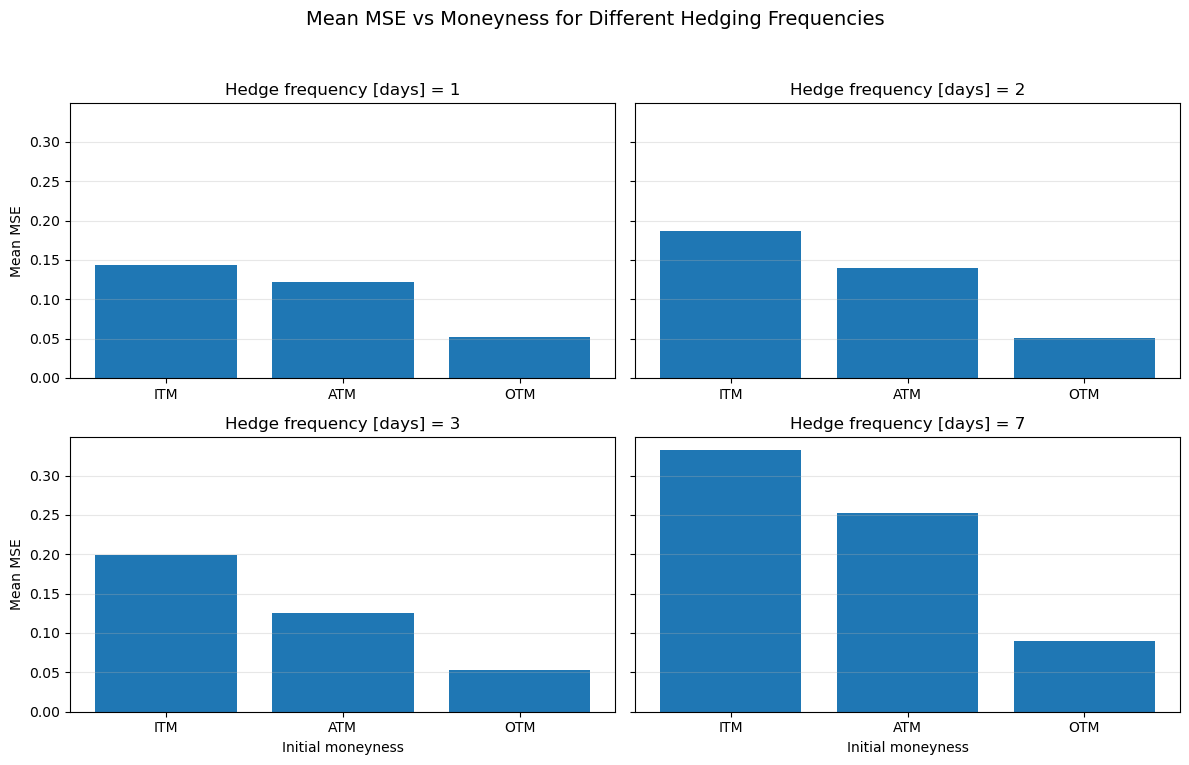

In [85]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True)
axes = axes.ravel()

for idx, freq in enumerate(frequencies):
    ax = axes[idx]

    df = aggregated_summary[aggregated_summary['hedge_frequency'] == freq]

    x = np.arange(len(df))
    means = df['mean_mse'].values
    stds = df['std_mse'].values
    labels = df['initial_moneyness'].astype(str).tolist()

    # ax.bar(x, means, yerr=stds)
    ax.bar(x, means)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    ax.set_title(f"Hedge frequency [days] = {freq}")
    ax.grid(axis="y", alpha=0.3)
    if idx % 2 == 0:
        ax.set_ylabel("Mean MSE")

for ax in axes[-2:]:
    ax.set_xlabel("Initial moneyness")

fig.suptitle("Mean MSE vs Moneyness for Different Hedging Frequencies", fontsize=14)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [86]:
aggregated_freq = (
    summary
    .groupby('hedge_frequency')['mse']
    .agg(
        mean_mse="mean",
        std_mse="std",
        n_options="count"
    )
    .reset_index()
    .sort_values("hedge_frequency")
)
aggregated_freq

,hedge_frequency,mean_mse,std_mse,n_options
0,1,0.105870,0.078383,30
1,2,0.125718,0.109052,30
2,3,0.125914,0.100311,30
3,7,0.224804,0.188625,30


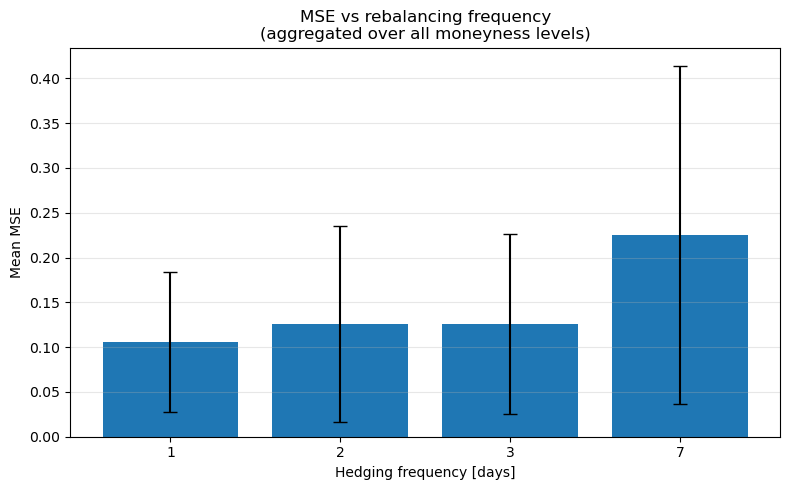

In [87]:
plt.figure(figsize=(8, 5))

x = np.arange(len(aggregated_freq))
means = aggregated_freq["mean_mse"].values
stds = aggregated_freq["std_mse"].values
labels = aggregated_freq["hedge_frequency"].astype(str).tolist()

plt.bar(x, means, yerr=stds, capsize=5)
plt.xticks(x, labels)

plt.xlabel("Hedging frequency [days]")
plt.ylabel("Mean MSE")
plt.title("MSE vs rebalancing frequency\n(aggregated over all moneyness levels)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

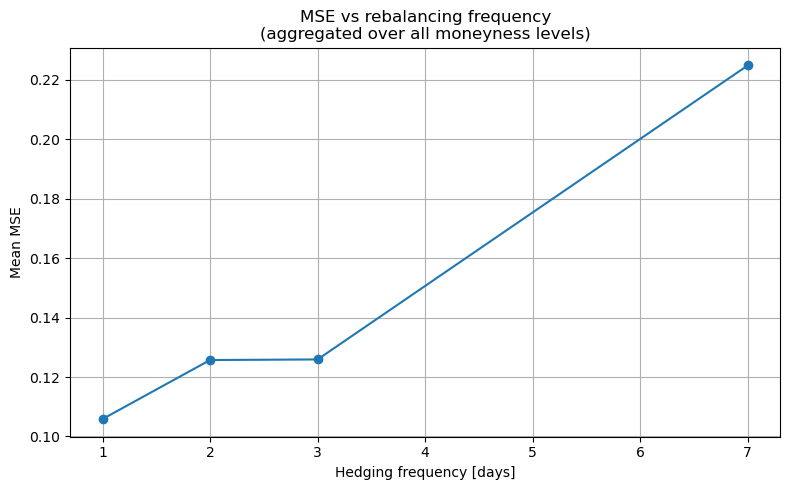

In [88]:
# for showing monotonicity
plt.figure(figsize=(8, 5))

plt.errorbar(
    aggregated_freq["hedge_frequency"],
    aggregated_freq["mean_mse"],
    fmt="o-",
    capsize=5
)

plt.xlabel("Hedging frequency [days]")
plt.ylabel("Mean MSE")
plt.title("MSE vs rebalancing frequency\n(aggregated over all moneyness levels)")
plt.grid(True)
plt.tight_layout()
plt.show()

Moneyness x Frequency interaction

In [89]:
pivot_mse = aggregated_summary.pivot(
    index='initial_moneyness',
    columns='hedge_frequency',
    values='mean_mse'
)

pivot_std = aggregated_summary.pivot(
    index='initial_moneyness',
    columns='hedge_frequency',
    values='std_mse'
)
pivot_mse


hedge_frequency,1,2,3,7
initial_moneyness,,,,
ITM,0.143393,0.186643,0.199566,0.332275
ATM,0.121753,0.139704,0.125138,0.252857
OTM,0.052464,0.050807,0.053037,0.089280


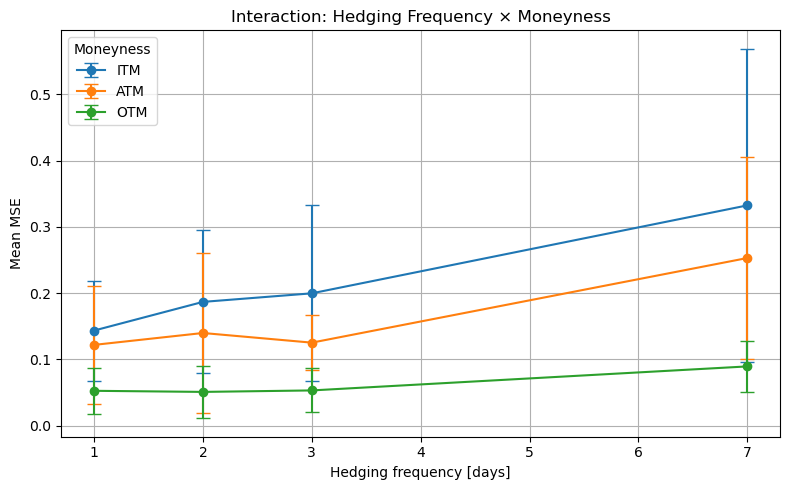

In [90]:
plt.figure(figsize=(8, 5))

for mon in moneyness_levels:
    df_mon = aggregated_summary[aggregated_summary["initial_moneyness"] == mon]
    plt.errorbar(
        df_mon["hedge_frequency"],
        df_mon["mean_mse"],
        yerr=df_mon["std_mse"],
        capsize=5,
        marker="o",
        label=mon
    )

plt.xlabel("Hedging frequency [days]")
plt.ylabel("Mean MSE")
plt.title("Interaction: Hedging Frequency × Moneyness")
plt.legend(title="Moneyness")
plt.grid(True)
plt.tight_layout()
plt.show()